In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext blackcellmagic

In [2]:
import gget

import sys
import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sc.set_figure_params(figsize=(6, 6), frameon=False)
# sc.settings.n_jobs=2

# Custom plotting functions
import funcs

22 Apr 2022 22:18:12 INFO Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
22 Apr 2022 22:18:12 INFO NumExpr defaulting to 8 threads.
22 Apr 2022 22:18:12 INFO dirname: Trying to get version of get_version from dirname /home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages
22 Apr 2022 22:18:12 INFO dirname: Failed; Does not match re.compile('get[_-]version-([\\d.]+?)(?:\\.dev(\\d+))?(?:[_+-]([0-9a-zA-Z.]+))?$')
22 Apr 2022 22:18:12 INFO git: Trying to get version from git in directory /home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages
22 Apr 2022 22:18:12 INFO git: Failed; directory is not managed by git
22 Apr 2022 22:18:12 INFO metadata: Trying to get version for get_version in dir /home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages
22 Apr 2022 22:18:12 INFO metadata: Succeeded
22 Apr 2022 22:18:12 INFO dirname: Trying to get version of legacy_api_wrap from dirname /home/lauraluebbert/bin/miniconda3/lib/py

___

Load the normalized and clustered:

In [3]:
adata = anndata.read_h5ad("macaque_norm_clustered.h5ad")
adata

AnnData object with n_obs × n_vars = 9991 × 35432
    obs: 'n_counts_processed', 'leiden'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

___

# Celltype assignment based on known marker genes

Define dictionary containing celltypes and their respective marker genes:

In [4]:
marker_gene_dict = {
    "amacrine cells": "ATP1B1",
    "astrocytes": "GFAP",
    "bipolar cells": "PCP2",
    "cones": "ARR3",
    "ganglion cells": "SNCG",
    "horizontal cells": "PVALB",
    "Müller glia": "FRZB",
    "microglia": "CD74",
    "endothelial cells/ pericytes": "IGFBP7",
    "rods": "rhodopsin",
}

Use gget to find the Ensembl IDs of known marker genes:

In [5]:
ens_marker_genes = gget.search(list(marker_gene_dict.values()), "macaca_m")
ens_marker_genes

22 Apr 2022 22:18:16 INFO Fetching results from database: macaca_mulatta_core_106_10
22 Apr 2022 22:18:21 INFO Query time: 8.09 seconds
22 Apr 2022 22:18:21 INFO Matches found: 11


,ensembl_id,gene_name,ensembl_description,ext_ref_description,biotype,url
0,ENSMMUG00000021078,ATP1B1,ATPase Na+/K+ transporting subunit beta 1 [Sou...,ATPase Na+/K+ transporting subunit beta 1,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene...
1,ENSMMUG00000013115,GFAP,glial fibrillary acidic protein [Source:VGNC S...,glial fibrillary acidic protein,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene...
2,ENSMMUG00000060224,PCP2,Purkinje cell protein 2 [Source:VGNC Symbol;Ac...,Purkinje cell protein 2,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene...
3,ENSMMUG00000013935,ARR3,arrestin 3 [Source:VGNC Symbol;Acc:VGNC:70020],arrestin 3,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene...
4,ENSMMUG00000011849,SNCG,synuclein gamma [Source:VGNC Symbol;Acc:VGNC:7...,synuclein gamma,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene...
5,ENSMMUG00000008778,PVALB,parvalbumin [Source:VGNC Symbol;Acc:VGNC:76627],parvalbumin,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene...
6,ENSMMUG00000014396,FRZB,frizzled related protein [Source:VGNC Symbol;A...,frizzled related protein,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene...
7,ENSMMUG00000009113,CD74,CD74 molecule [Source:VGNC Symbol;Acc:VGNC:70779],CD74 molecule,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene...
8,ENSMMUG00000014011,IGFBP7,insulin like growth factor binding protein 7 [...,insulin like growth factor binding protein 7,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene...
9,ENSMMUG00000021223,RRH,retinal pigment epithelium-derived rhodopsin h...,retinal pigment epithelium-derived rhodopsin h...,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene...


Find these IDs in the dataset (this approach has the advantage that even genes that were not annotated with their gene name in the reference genome can be found):

In [6]:
marker_genes = funcs.find_ids(adata, ens_marker_genes["ensembl_id"].values)

Plot the expression of these marker genes per Leiden cluster in a heatmap:

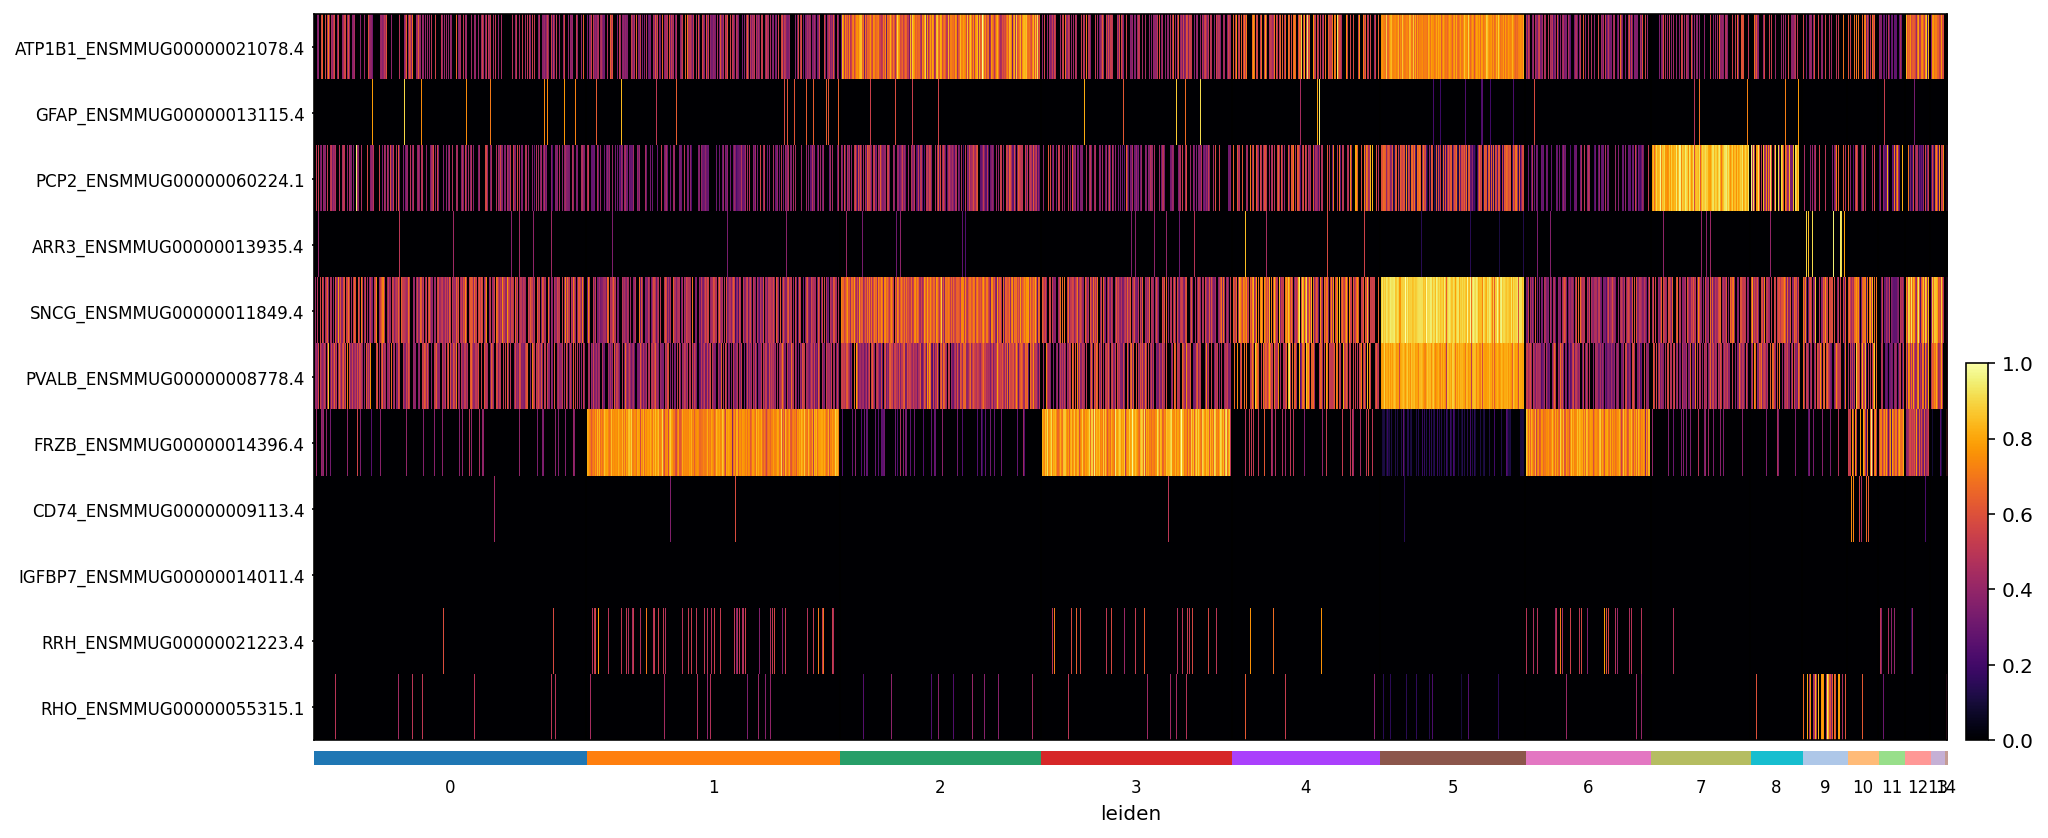

In [7]:
# var_group_positions = []
# for i in np.arange(len(marker_gene_dict.keys())+1):
#     var_group_positions.append((i,i))

sc.pl.heatmap(
    adata,
    marker_genes,
    groupby="leiden",
    show_gene_labels=True,
#     var_group_positions=var_group_positions,
#     var_group_labels=list(marker_gene_dict.keys()),
#     var_group_rotation=0.5,
    use_raw=False, 
    cmap="inferno", 
    standard_scale="var",
    swap_axes=True,
    save=True,
    figsize=(15, 7)
)

Run DE gene analysis on only the known marker genes:

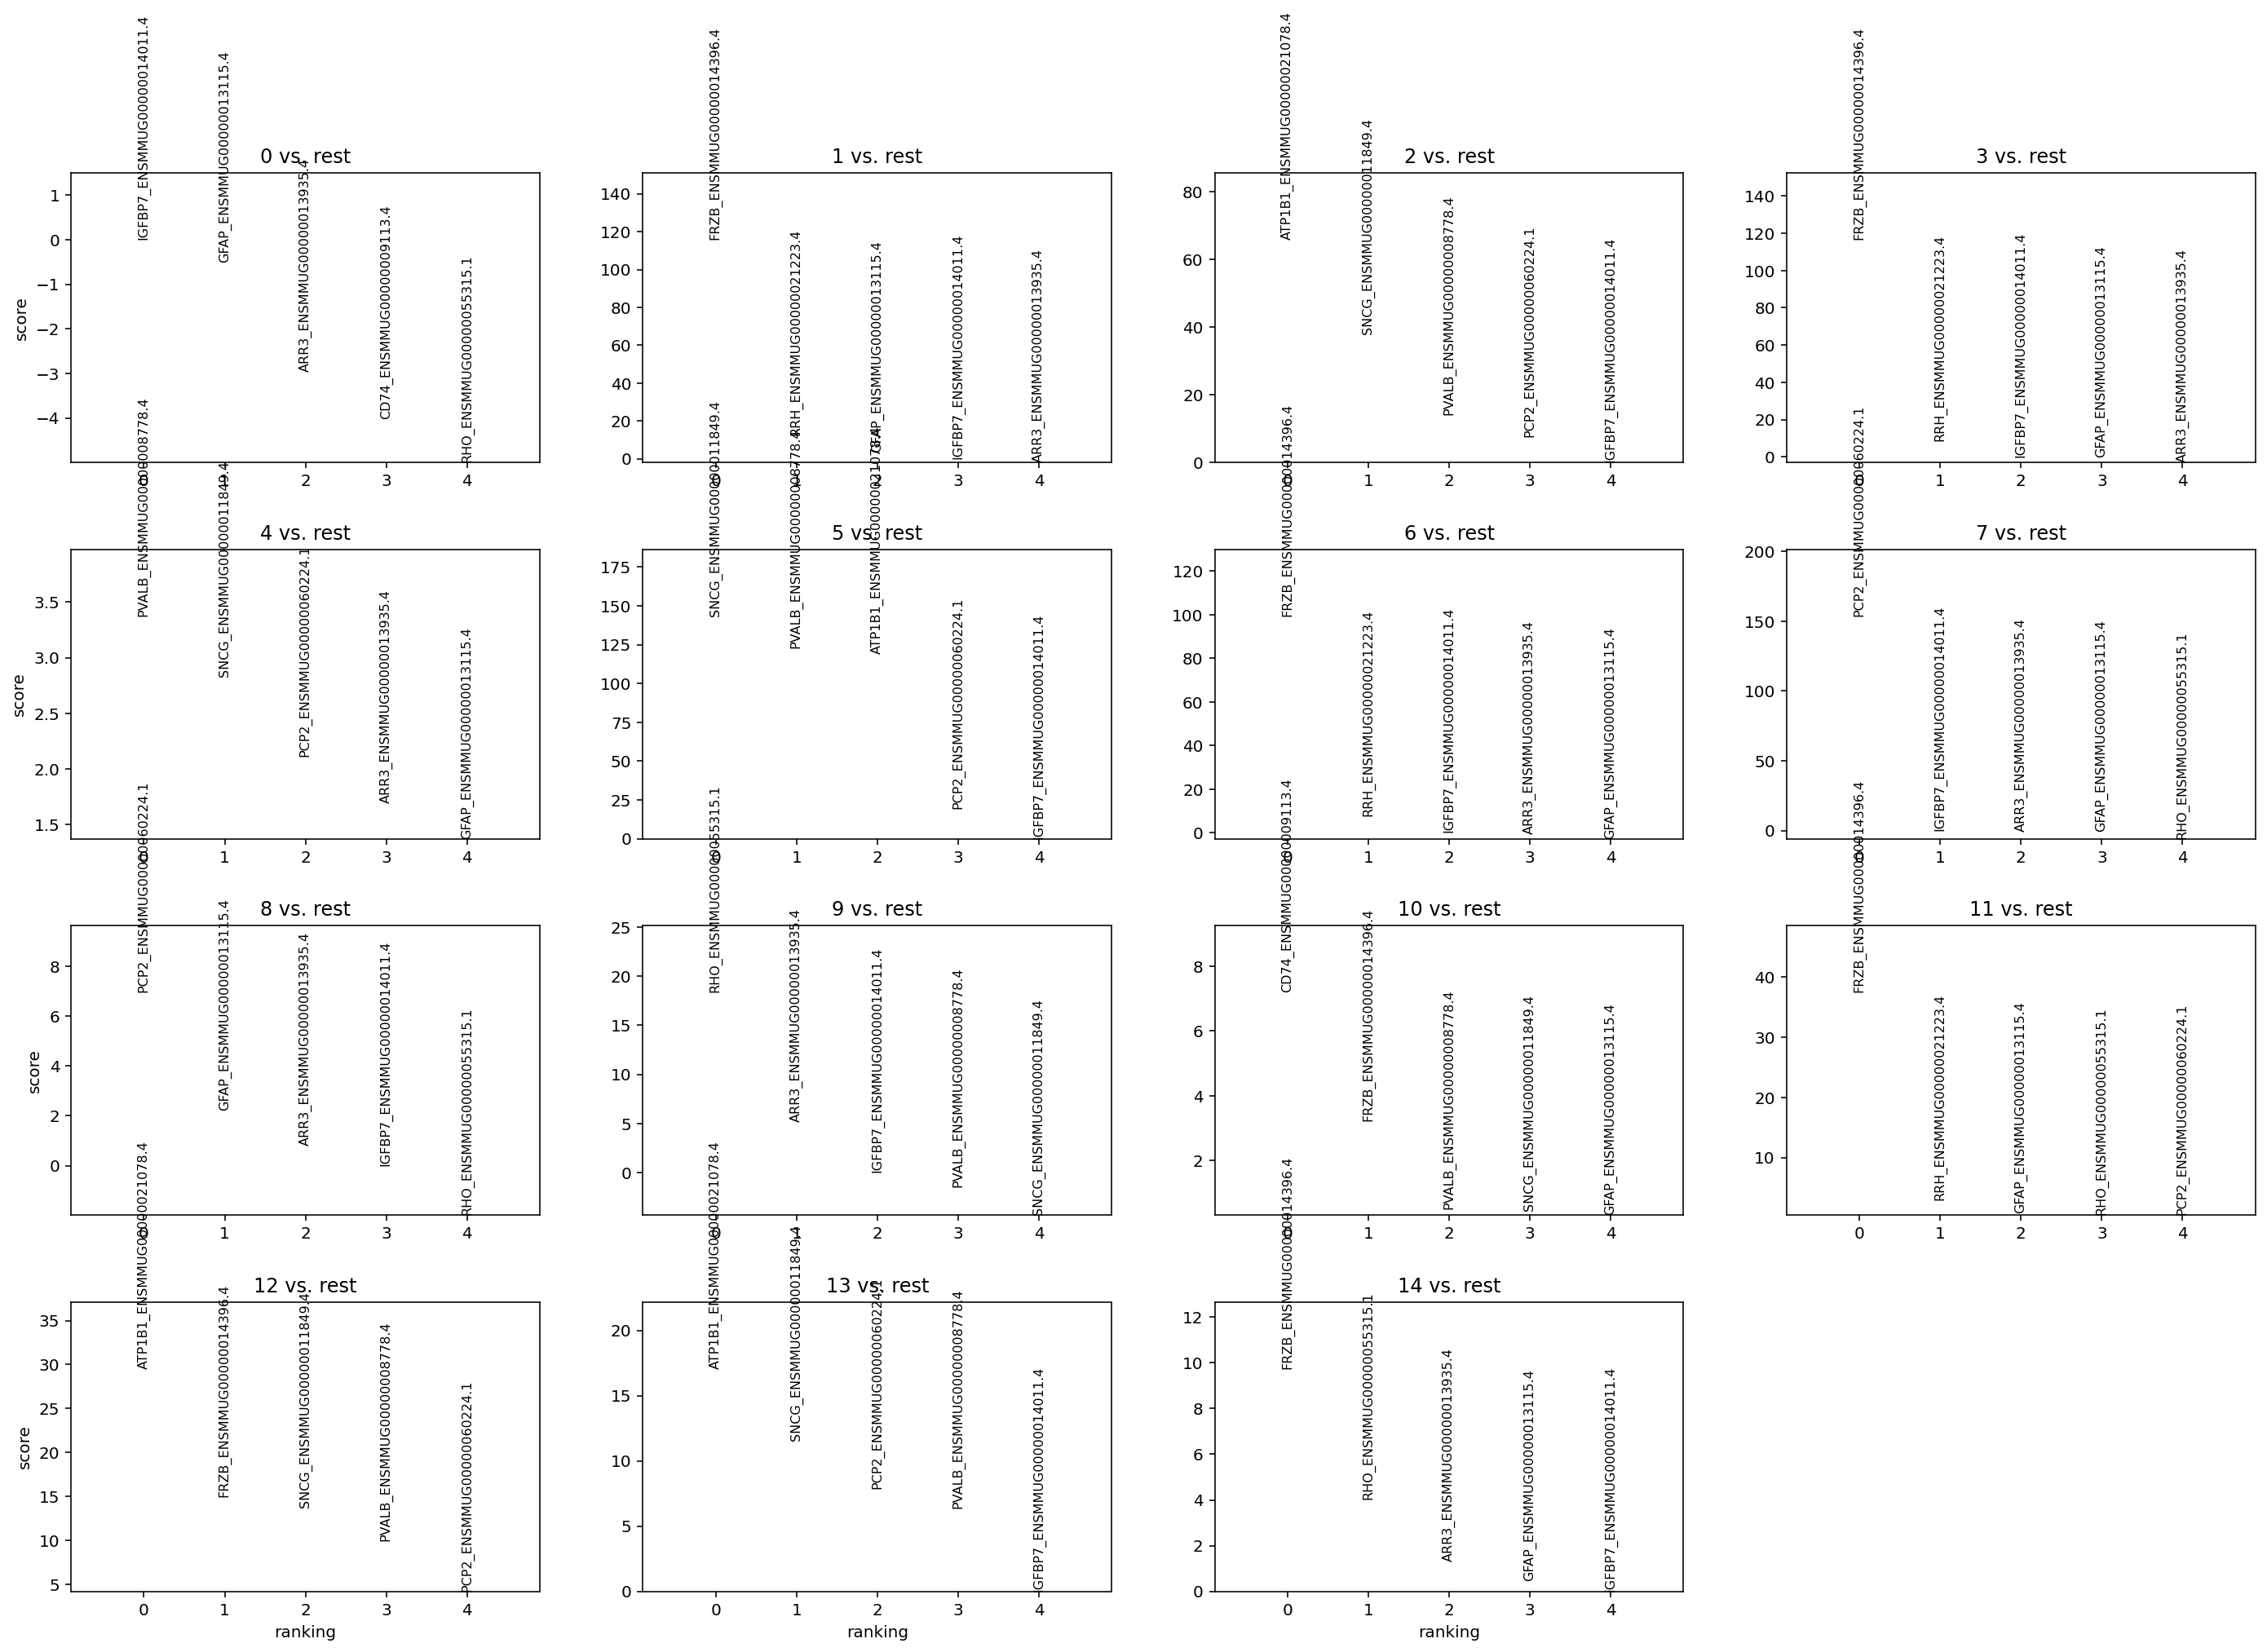

In [8]:
adata_test = adata.copy()

# Find indices of all marker genes in adata
ens_idx = np.isin(adata_test.var_names, marker_genes)

# Slice adata based on these indices
adata_test = adata_test[:,ens_idx].copy()

sc.tl.rank_genes_groups(adata_test, groupby='leiden', method='t-test', corr_method="bonferroni", use_raw=False)
sc.pl.rank_genes_groups(adata_test, n_genes=5, sharey=False, save=False)

In [9]:
marker_gene_dict

{'amacrine cells': 'ATP1B1',
 'astrocytes': 'GFAP',
 'bipolar cells': 'PCP2',
 'cones': 'ARR3',
 'ganglion cells': 'SNCG',
 'horizontal cells': 'PVALB',
 'Müller glia': 'FRZB',
 'microglia': 'CD74',
 'endothelial cells/ pericytes': 'IGFBP7',
 'rods': 'rhodopsin'}

Define celltype per Leiden cluster:

In [10]:
df_leiden = pd.DataFrame()
df_leiden["leiden_cluster"] = np.arange(15)
# Define cluster celltype
df_leiden["celltype"] = [
    "Endothelial cells/\npericytes 1",
    "Müller glia 3",
    "Amacrine cells 2",
    "Müller glia 2",
    "Horizontal cells",
    "Ganglion cells 1",
    "Müller glia 4",
    "Bipolar cells 1",
    "Bipolar cells 2",
    "Rods 1",
    "Microglia",
    "Müller glia 1",
    "Amacrine cells 1",
    "Ganglion cells 2",
    "Rods 2",
]

df_leiden["celltype_colors"] = [
    "cornflowerblue",
    "coral",
    "mediumseagreen",
    "orangered",
    "darkblue",
    "indigo",
    "moccasin",
    "royalblue",
    "lightskyblue",
    "mediumvioletred",
    "darkorange",
    "crimson",
    "darkgreen",
    "mediumpurple",
    "orchid",
]

df_leiden

,leiden_cluster,celltype,celltype_colors
0,0,Endothelial cells/\npericytes 1,cornflowerblue
1,1,Müller glia 3,coral
2,2,Amacrine cells 2,mediumseagreen
3,3,Müller glia 2,orangered
4,4,Horizontal cells,darkblue
5,5,Ganglion cells 1,indigo
6,6,Müller glia 4,moccasin
7,7,Bipolar cells 1,royalblue
8,8,Bipolar cells 2,lightskyblue
9,9,Rods 1,mediumvioletred


Add manually defined celltypes to AnnData object:

In [11]:
# Create copy of leiden cluster column to store manually assigned celltypes
adata.obs["celltype"] = adata.obs.leiden.copy()

# Relabel the clusters in celltype
adata.rename_categories("celltype", df_leiden["celltype"].values)

Rank celltypes based on DE genes (similar celltypes should cluster together):

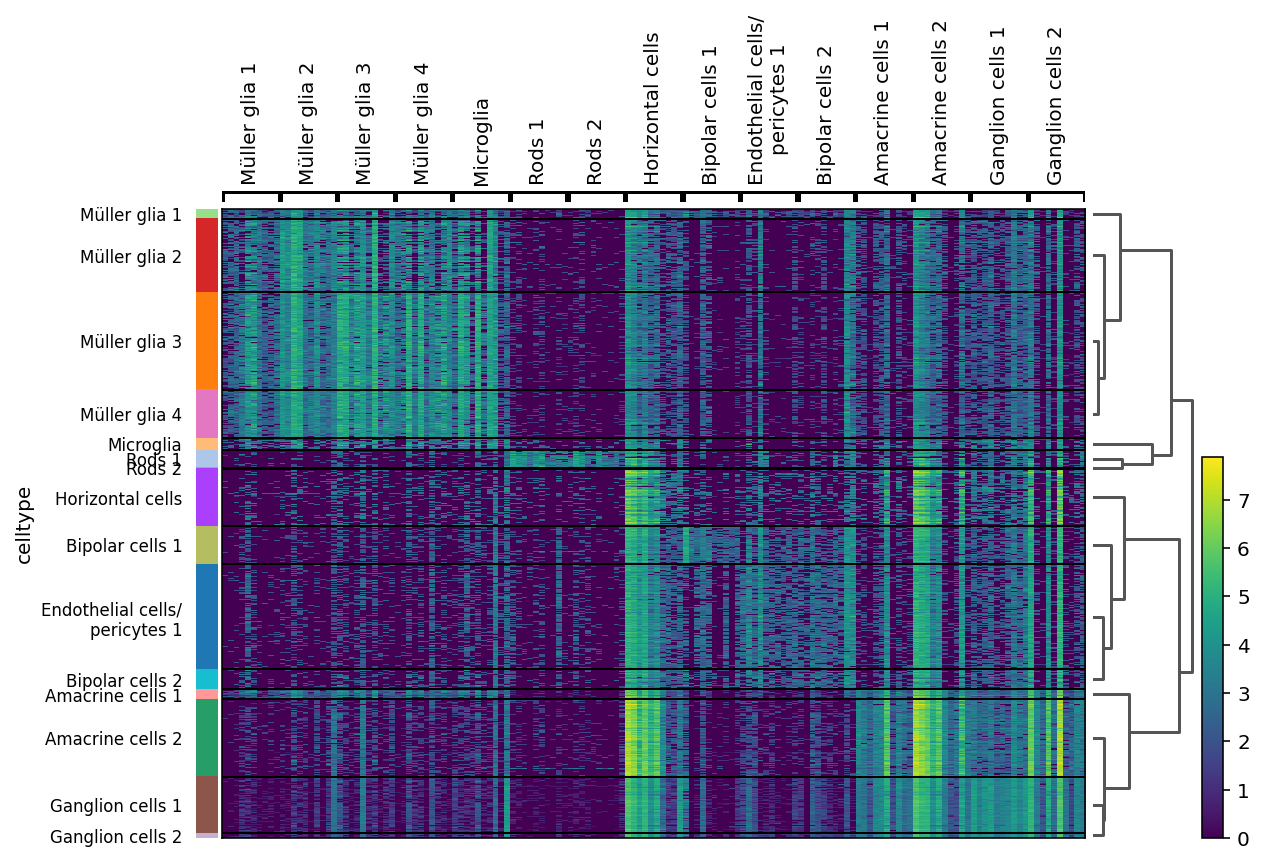

In [12]:
sc.tl.rank_genes_groups(
    adata,
    groupby="celltype",
    use_raw=False,
    method="wilcoxon",
    corr_method="bonferroni",
)

# Run sc.pl.rank_genes_groups_heatmap once to create adata.uns["celltype_colors"] object
sc.pl.rank_genes_groups_heatmap(
    adata,
    show_gene_labels=False,
    use_raw=False,
    show=False
)

# Relabel celltype colors
adata.uns["celltype_colors"] = df_leiden["celltype_colors"]

In [13]:
adata.uns["celltype_colors"] = df_leiden["celltype_colors"]

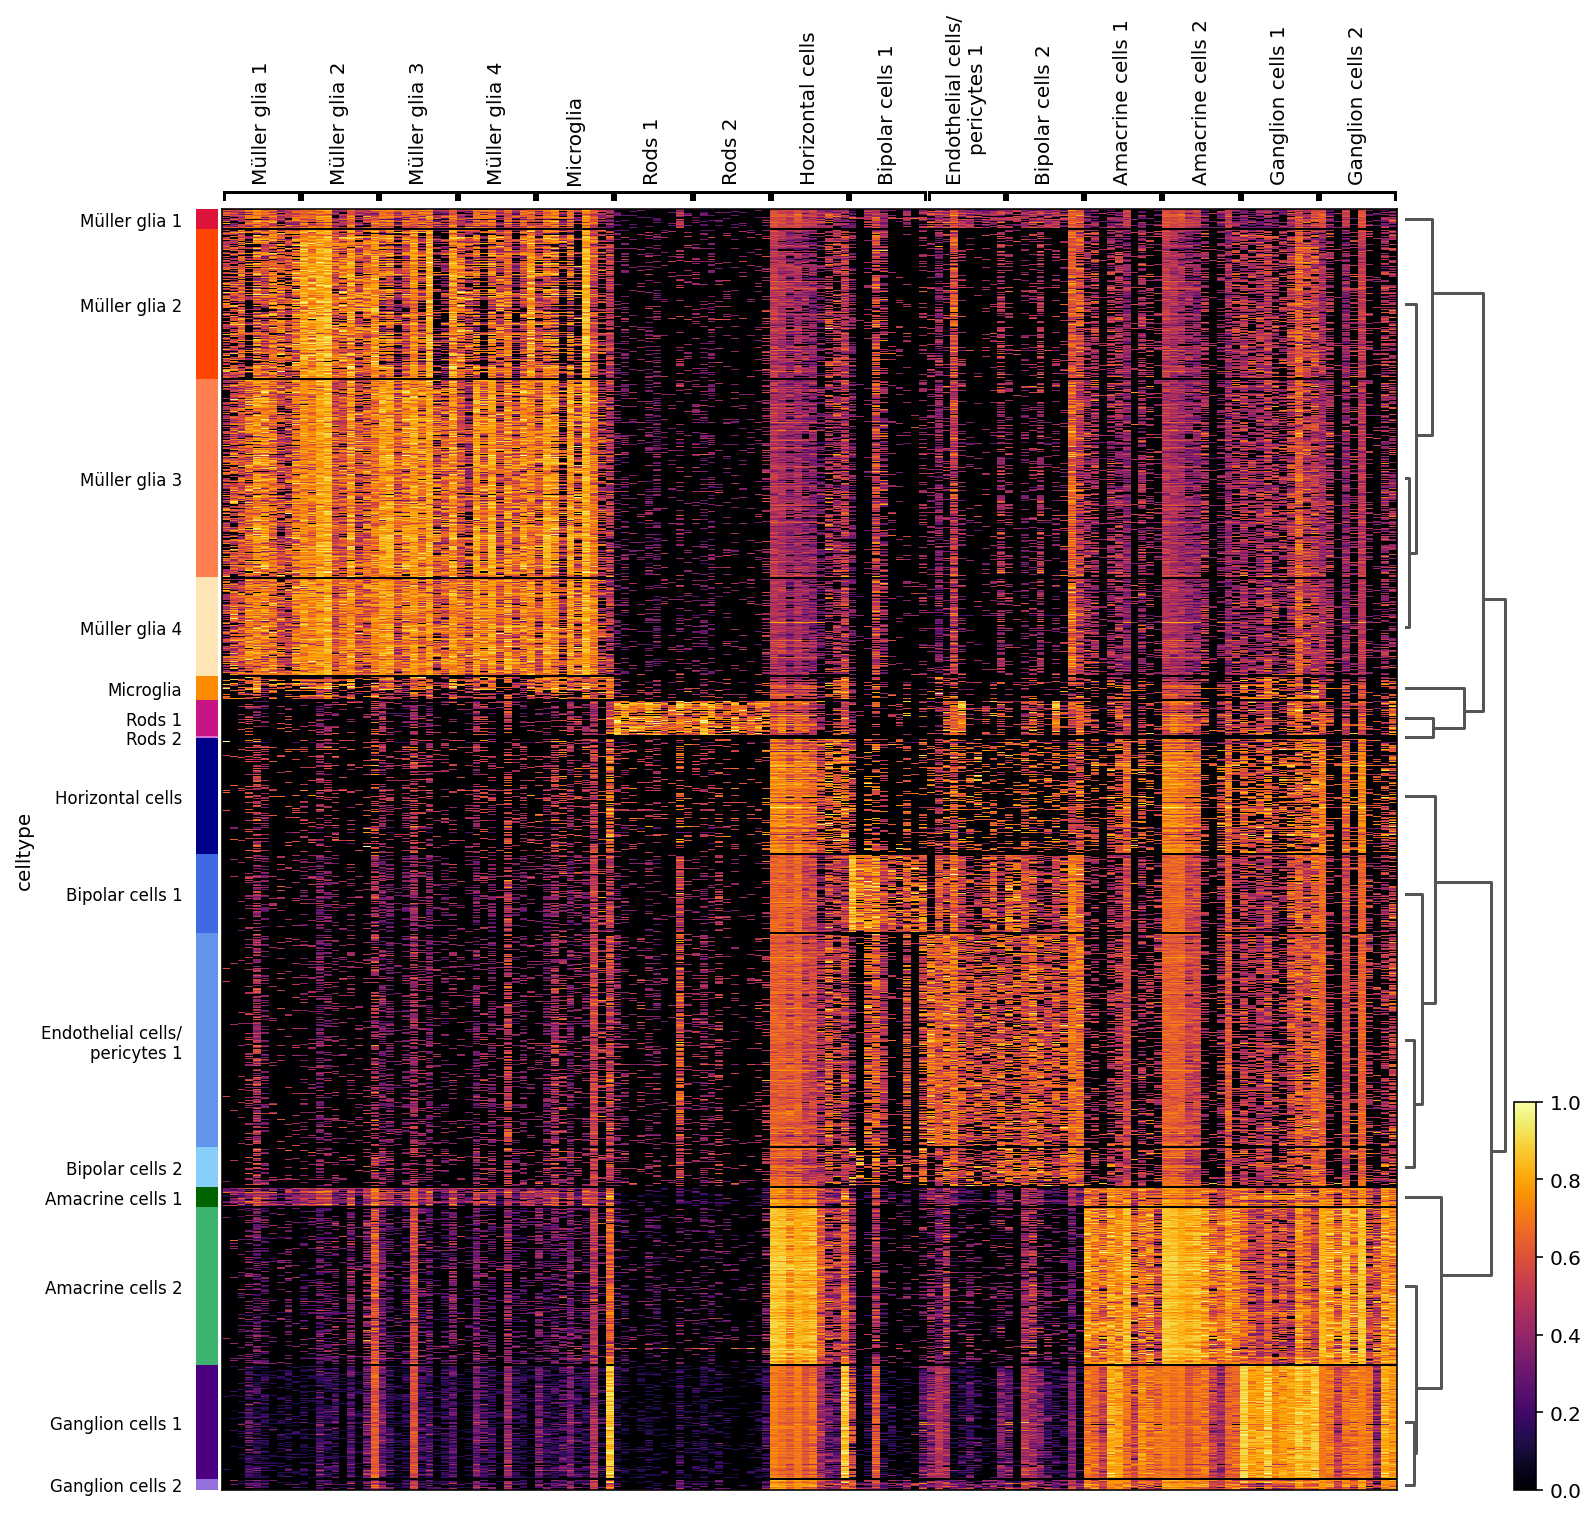

In [14]:
# Plot heatmap
sc.pl.rank_genes_groups_heatmap(
    adata,
    show_gene_labels=False,
    use_raw=False,
    cmap="inferno",
    standard_scale="var",
    save=True,
    figsize=(12, 12)
)

___

# Differentially expressed genes analysis

Define masks for conditions to compare:

In [15]:
# # Comparing more than one cluster per group:
# control_mask = np.logical_or(adata.obs["celltype"]=="Bipolar cells 1", adata.obs["celltype"]=="Bipolar cells 2")
# experiment_mask = np.logical_or(adata.obs["celltype"]=="Ganglion cells 1", adata.obs["celltype"]=="Ganglion cells 2")

# Comparing just two clusters:
control_mask = np.where(adata.obs["celltype"]=="Bipolar cells 1")
experiment_mask = np.where(adata.obs["celltype"]=="Bipolar cells 2")

Compute values for volcano plot:

In [16]:
df_volcano = funcs.volcano_df(adata, control_mask, experiment_mask)
df_volcano.head()

,GeneNames,control,experiment,logFC,p-value
0,_ENSMMUG00000023296.4,0.000000,0.000000,0.000000,NaN
1,U6_ENSMMUG00000036181.3,0.000000,0.000000,0.000000,NaN
2,ZNF692_ENSMMUG00000000634.4,0.058549,0.031487,0.027063,0.172397
3,ZNF672_ENSMMUG00000037875.2,0.003024,0.013586,-0.010562,0.294305
4,SH3BP5L_ENSMMUG00000000632.4,0.096787,0.066643,0.030144,0.253028


Plot volcano plot:

In [17]:
# Define minimum fold change and p-value alpha for volcano plot
min_fold_change = 2
alpha = 0.05

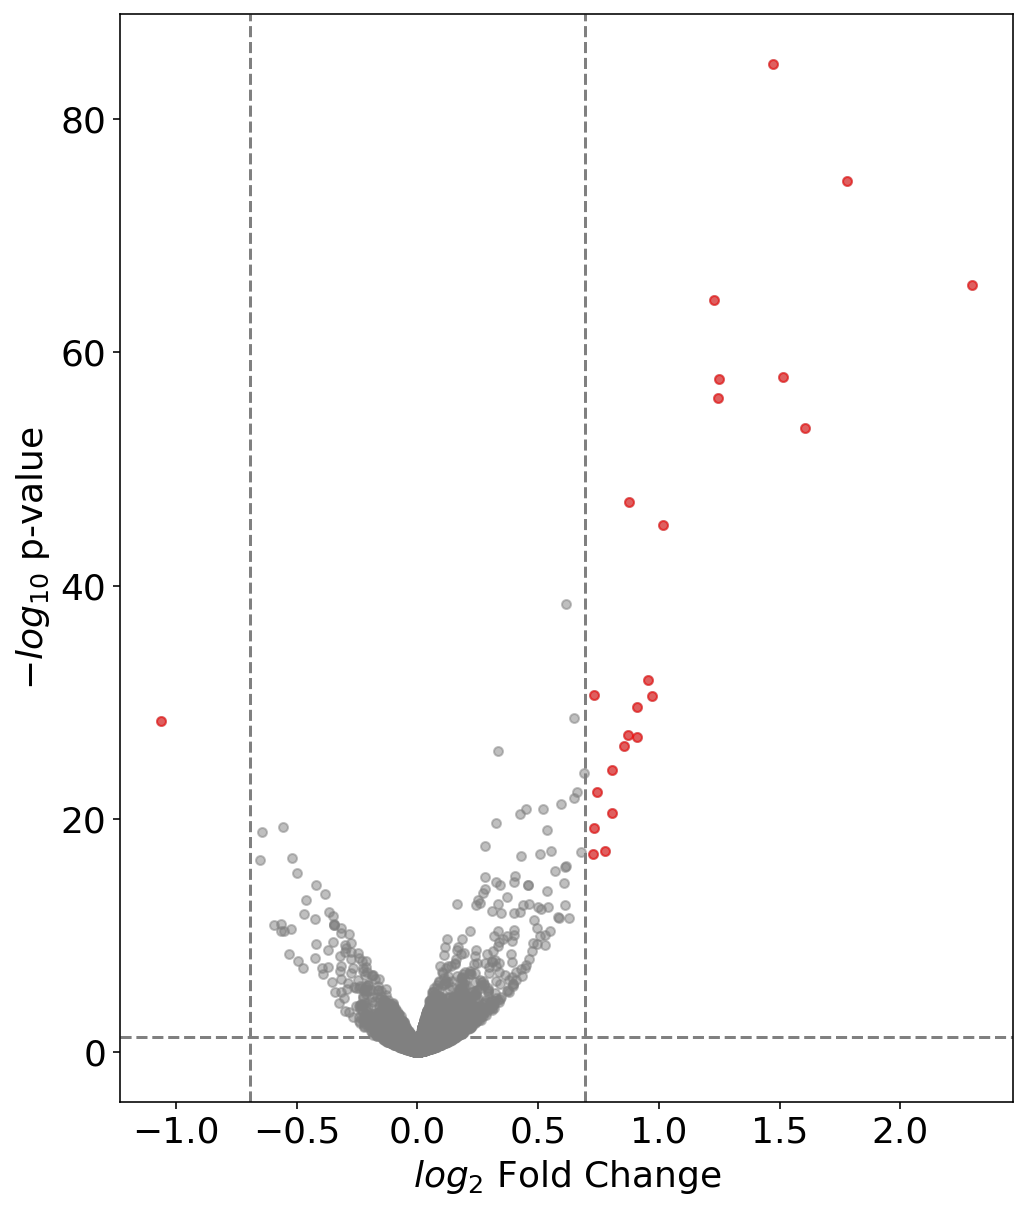

In [18]:
funcs.volcano_plot(df_volcano, min_fold_change=min_fold_change, alpha=alpha)

Find genes that were significantly higher in first condition:

In [30]:
mask1 = np.logical_and(df_volcano["logFC"] < -np.log(min_fold_change), df_volcano["p-value"] < alpha)
df_volcano[mask1].sort_values("logFC")

,GeneNames,control,experiment,logFC,p-value
34848,_ENSMMUG00000065373.1,1.279495,2.342443,-1.062948,3.947597e-29


Find genes that were significantly higher in second condition:

In [66]:
mask2 = np.logical_and(df_volcano["logFC"] > np.log(min_fold_change), df_volcano["p-value"] < alpha)
df_de_genes = df_volcano[mask2].sort_values("logFC")
df_de_genes

,GeneNames,control,experiment,logFC,p-value
2136,CYP2J2_ENSMMUG00000015972.4,1.824458,1.097520,0.726937,9.557162e-18
9711,PRDM8_ENSMMUG00000051357.1,0.988058,0.255780,0.732278,2.310368e-31
15299,_ENSMMUG00000054106.1,1.773402,1.040951,0.732451,6.638133e-20
5631,_ENSMMUG00000053116.1,1.253115,0.508457,0.744658,4.973337e-23
4544,_ENSMMUG00000021246.4,2.128292,1.353531,0.774762,5.712902e-18
19597,GNB3_ENSMMUG00000005190.4,2.247942,1.442241,0.805701,2.895324e-21
11768,EDIL3_ENSMMUG00000007661.4,1.501093,0.694273,0.806820,6.525091e-25
13813,TRPM1_ENSMMUG00000009430.4,1.588233,0.731630,0.856603,5.497136e-27
24230,_ENSMMUG00000051202.1,1.599528,0.725774,0.873754,6.553672e-28
32465,MT1M_ENSMMUG00000054142.1,1.022746,0.147984,0.874762,6.287600e-48


Check if CCDC136_ENSMMUG00000009625.4 was annotated correctly:

In [19]:
seq = gget.seq("ENSMMUG00000009625")[1]
blast_results = gget.blast(seq)

22 Apr 2022 22:27:45 INFO Requesting nucleotide sequence of ENSMMUG00000009625 from Ensembl.
22 Apr 2022 22:27:45 INFO Sequence recognized as nucleotide sequence.
22 Apr 2022 22:27:45 INFO BLAST will use program 'blastn' with database 'nt'.
22 Apr 2022 22:27:46 INFO BLAST initiated with search ID 673JJRUT016. Estimated time to completion: 46 seconds.
22 Apr 2022 22:28:33 INFO BLASTING...
22 Apr 2022 22:29:35 INFO BLASTING...
22 Apr 2022 22:30:37 INFO Retrieving results...


In [22]:
from IPython.display import display, HTML

def wrap_df_text(df):
    return display(HTML(blast_results.to_html().replace("\\n","<br>")))

blast_results['Description'] = blast_results['Description'].str.wrap(30)

wrap_df_text(blast_results)

,Description,Scientific Name,Common Name,Taxid,Max Score,Total Score,Query Cover,E value,Per. Ident,Acc. Len,Accession
0,"Pan troglodytes BAC cloneCH251-587P5 from chromosome 7,complete sequence",Pan troglodytes,chimpanzee,9598,23019,88695,99%,0.0,93.26%,201552,AC192999.3
1,"Homo sapiens chromosome 7clone RP11-309L24, completesequence",Homo sapiens,human,9606,22969,69933,58%,0.0,93.20%,200197,AC025594.5
2,"Homo sapiens chromosome 7clone RP11-66F23, completesequence",Homo sapiens,human,9606,22925,97506,98%,0.0,93.15%,182426,AC024952.4
3,"Homo sapiens filamin C (FLNC),RefSeqGene (LRG_870) onchromosome 7",Homo sapiens,human,9606,10912,12777,20%,0.0,92.35%,35846,NG_011807.1
4,"PREDICTED: Cercocebus atyscoiled-coil domain containing136 (CCDC136), transcriptvariant X6, mRNA",Cercocebus atys,sooty mangabey,9531,7845,14343,18%,0.0,99.17%,7945,XM_012087990.1
5,"PREDICTED: Cercocebus atyscoiled-coil domain containing136 (CCDC136), transcriptvariant X3, mRNA",Cercocebus atys,sooty mangabey,9531,7845,13242,17%,0.0,99.17%,7342,XM_012087987.1
6,"PREDICTED: Chlorocebus sabaeuscoiled-coil domain containing136 (CCDC136), transcriptvariant X5, mRNA",Chlorocebus sabaeus,green monkey,60711,7716,10129,13%,0.0,98.60%,6015,XM_038004403.1
7,"PREDICTED: Chlorocebus sabaeuscoiled-coil domain containing136 (CCDC136), transcriptvariant X7, mRNA",Chlorocebus sabaeus,green monkey,60711,7714,14268,19%,0.0,98.60%,8292,XM_038004404.1
8,"PREDICTED: Piliocolobustephrosceles coiled-coildomain containing 136(CCDC136), transcript variantX6, mRNA",Piliocolobus tephrosceles,Ugandan red Colobus,591936,7328,13722,19%,0.0,96.95%,7969,XM_023223477.1
9,"PREDICTED: Aotus nancymaaecoiled-coil domain containing136 (CCDC136), mRNA",Aotus nancymaae,Ma's night monkey,37293,5605,10647,18%,0.0,89.89%,7731,XM_012474082.2


,Description,Scientific Name,Common Name,Taxid,Max Score,Total Score,Query Cover,E value,Per. Ident,Acc. Len,Accession
0,Pan troglodytes BAC clone\nCH251-587P5 from ch...,Pan troglodytes,chimpanzee,9598,23019,88695,99%,0.0,93.26%,201552,AC192999.3
1,"Homo sapiens chromosome 7\nclone RP11-309L24, ...",Homo sapiens,human,9606,22969,69933,58%,0.0,93.20%,200197,AC025594.5
2,"Homo sapiens chromosome 7\nclone RP11-66F23, c...",Homo sapiens,human,9606,22925,97506,98%,0.0,93.15%,182426,AC024952.4
3,"Homo sapiens filamin C (FLNC),\nRefSeqGene (LR...",Homo sapiens,human,9606,10912,12777,20%,0.0,92.35%,35846,NG_011807.1
4,PREDICTED: Cercocebus atys\ncoiled-coil domain...,Cercocebus atys,sooty mangabey,9531,7845,14343,18%,0.0,99.17%,7945,XM_012087990.1
5,PREDICTED: Cercocebus atys\ncoiled-coil domain...,Cercocebus atys,sooty mangabey,9531,7845,13242,17%,0.0,99.17%,7342,XM_012087987.1
6,PREDICTED: Chlorocebus sabaeus\ncoiled-coil do...,Chlorocebus sabaeus,green monkey,60711,7716,10129,13%,0.0,98.60%,6015,XM_038004403.1
7,PREDICTED: Chlorocebus sabaeus\ncoiled-coil do...,Chlorocebus sabaeus,green monkey,60711,7714,14268,19%,0.0,98.60%,8292,XM_038004404.1
8,PREDICTED: Piliocolobus\ntephrosceles coiled-c...,Piliocolobus tephrosceles,Ugandan red Colobus,591936,7328,13722,19%,0.0,96.95%,7969,XM_023223477.1
9,PREDICTED: Aotus nancymaae\ncoiled-coil domain...,Aotus nancymaae,Ma's night monkey,37293,5605,10647,18%,0.0,89.89%,7731,XM_012474082.2


Get the nucleotide sequence of all DE genes:

In [67]:
# Get the Ensembl ID of all the DE genes
de_genes = []
for gene in df_de_genes["GeneNames"].values:
    de_genes.append(gene.split("_")[1])

# Get the nucleotide sequence of all genes
seqs = gget.seq(de_genes)

22 Apr 2022 20:06:28 INFO Requesting nucleotide sequence of ENSMMUG00000015972 from Ensembl.
22 Apr 2022 20:06:28 INFO Requesting nucleotide sequence of ENSMMUG00000051357 from Ensembl.
22 Apr 2022 20:06:29 INFO Requesting nucleotide sequence of ENSMMUG00000054106 from Ensembl.
22 Apr 2022 20:06:29 INFO Requesting nucleotide sequence of ENSMMUG00000053116 from Ensembl.
22 Apr 2022 20:06:31 INFO Requesting nucleotide sequence of ENSMMUG00000021246 from Ensembl.
22 Apr 2022 20:06:31 INFO Requesting nucleotide sequence of ENSMMUG00000005190 from Ensembl.
22 Apr 2022 20:06:33 INFO Requesting nucleotide sequence of ENSMMUG00000007661 from Ensembl.
22 Apr 2022 20:06:35 INFO Requesting nucleotide sequence of ENSMMUG00000009430 from Ensembl.
22 Apr 2022 20:06:35 INFO Requesting nucleotide sequence of ENSMMUG00000051202 from Ensembl.
22 Apr 2022 20:06:36 INFO Requesting nucleotide sequence of ENSMMUG00000054142 from Ensembl.
22 Apr 2022 20:06:36 INFO Requesting nucleotide sequence of ENSMMUG000

For each sequence, look up the chromosome location. Since no mucaca genomes are available on https://genome.ucsc.edu/cgi-bin/hgBlat, we will use the default human genome.

In [70]:
# Get the chromosome location of all genes
df_list = []

# The nucleotide sequences are the second element in the fasta list
for seq in seqs[1::2]:
    # Only keep the best results for each sequence
    df_list.append(gget.blat(seq).head(1))
    
df_blat = pd.concat(df_list)
df_blat = df_blat.reset_index(drop=True)

22 Apr 2022 20:07:01 INFO Length of sequence is > 8000. Only the fist 8000 characters will be submitted to BLAT.
22 Apr 2022 20:07:01 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.
22 Apr 2022 20:07:03 INFO Length of sequence is > 8000. Only the fist 8000 characters will be submitted to BLAT.
22 Apr 2022 20:07:03 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.
22 Apr 2022 20:07:05 INFO Length of sequence is > 8000. Only the fist 8000 characters will be submitted to BLAT.
22 Apr 2022 20:07:05 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.
22 Apr 2022 20:07:06 INFO Length of sequence is > 8000. Only the fist 8000 characters will be submitted to BLAT.
22 Apr 2022 20:07:06 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.
22 Apr 2022 20:07:08 INFO Length of sequence is > 8000. Only the fist 8000 characters will be submitted to BLAT.
22 Apr 2022 20:07:08 INFO Sequence 

In [74]:
# Add gene names and logFC to BLAT results data frame
df_blat["gene"] = de_genes
df_blat["logFC"] = df_de_genes["logFC"].values

In [81]:
df_blat

,genome,query_size,aligned_start,aligned_end,matches,mismatches,total_%_aligned,chromosome,strand,start,end,gene_name,logFC
0,hg38,8000,39,8000,7330,427,91.62,chr1,-,59918571,59926784,ENSMMUG00000015972.4,0.726937
1,hg38,8000,8,8000,7432,394,92.90,chr4,+,80183853,80191788,ENSMMUG00000051357.1,0.732278
2,hg38,8000,1,8000,7589,348,94.86,chr8,+,64373309,64381298,ENSMMUG00000054106.1,0.732451
3,hg38,8000,1,8000,7430,287,92.88,chr7,+,94656370,94664403,ENSMMUG00000053116.1,0.744658
4,hg38,8000,1,7959,6809,372,85.11,chr3,-,42794545,42804512,ENSMMUG00000021246.4,0.774762
5,hg38,6396,1,6396,6015,311,94.04,chr12,+,6840936,6847390,ENSMMUG00000005190.4,0.805701
6,hg38,8000,1,8000,7511,354,93.89,chr5,-,84376503,84384880,ENSMMUG00000007661.4,0.806820
7,hg38,8000,1,8000,7164,527,89.55,chr15_KN538374v1_fix,-,3320867,3334271,ENSMMUG00000009430.4,0.856603
8,hg38,3784,1,3784,3480,220,91.97,chr11,+,84972951,84976703,ENSMMUG00000051202.1,0.873754
9,hg38,8000,2,7369,5677,552,70.96,chr16,+,56625770,56637608,ENSMMUG00000054142.1,0.874762


Check if there is a correlation between fold change and chromosome location:

In [89]:
# Drop index 7 to make barplot axis labels prettier
df_blat = df_blat.drop(7)

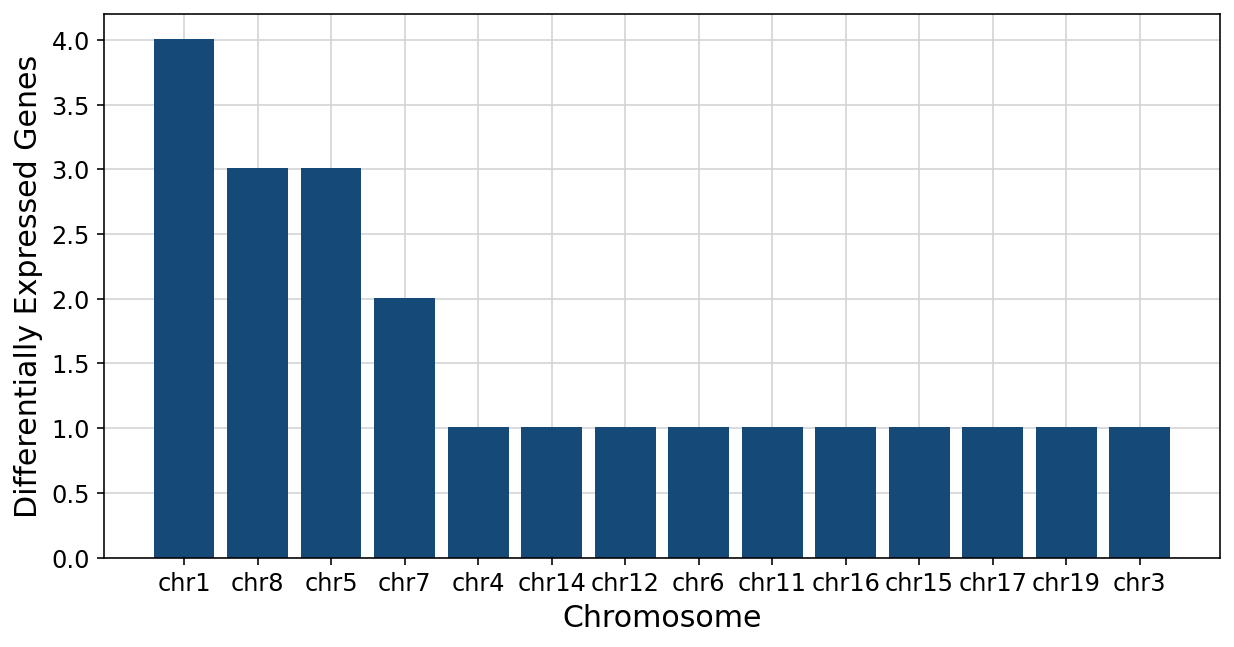

In [114]:
fig, ax = plt.subplots(figsize=(10,5))

fontsize = 15
color = "#154A78"
edgecolor = color

x = df_blat["chromosome"].value_counts().index
y = df_blat["chromosome"].value_counts().values
ax.bar(x, y, color=color, edgecolor=edgecolor)

ax.set_xlabel("Chromosome", fontsize=fontsize)
ax.set_ylabel("Differentially Expressed Genes", fontsize=fontsize)
# Change fontsize of tick labels
ax.tick_params(axis="both", labelsize=fontsize-3)
    
# Add grid and set below graph
ax.grid(True, which="both", color="lightgray")
ax.set_axisbelow(True)

fig.savefig("figures/4_chr_barplot.png", dpi=300, bbox_inches='tight')  
fig.savefig("figures/4_chr_barplot.pdf", dpi=300, bbox_inches='tight')
    
fig.show()

___

Fetch all isoforms and align:

In [25]:
isoforms = gget.seq("ENSMMUG00000009625", seqtype="transcript", isoforms=True, save=True)

22 Apr 2022 22:40:55 INFO Requesting amino acid sequences of all transcripts of gene ENSMMUG00000009625 from UniProt.


In [26]:
gget.muscle("seq_results.fa")

22 Apr 2022 22:41:07 INFO MUSCLE compiled. 
22 Apr 2022 22:41:07 INFO MUSCLE aligning... 

muscle 5.2.linux64 [00617b]  396Gb RAM, 48 cores
Built Apr 13 2022 00:43:46
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

Input: 10 seqs, avg length 858, max 1208

00:00 23Mb   CPU has 48 cores, defaulting to 20 threads
00:00 1.7Gb   100.0% Calc posteriors
00:00 1.5Gb   100.0% Consistency (1/2)
00:00 1.5Gb   100.0% Consistency (2/2)
00:00 1.5Gb   100.0% UPGMA5           
00:01 1.5Gb   100.0% Refining
22 Apr 2022 22:41:08 INFO MUSCLE alignment complete. Alignment time: 0.97 seconds




ENSMMUT00000081345 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000013452 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000096620 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000013440 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000041838 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000013454 MSPSLHPSPQPVPHPPALPFSV-LSGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000092110 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000013450 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000086187 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEEE
ENSMMUT00000094799 MEAGAGAGAGA------AGWSCPGPGPTVTTLGSYEASEGCERKKGQRWGSLERRGMQAMEGEVLLPALYEEEEEEEEE

____